In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F
from sklearn.metrics import mean_absolute_error
import sklearn
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id
import re
from collections import Counter


# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/14 19:18:52 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.21.139.150 instead (on interface eth0)
22/10/14 19:18:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/14 19:18:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Summary

### Introduction

**Team Members:** Aryan Shahi, Jai Bretherton, Eesha Syed, Minma Herath

The goal of this project and repository was to select the 100 most profitable merchants to onboard for the new pay in 5 installments plan.

### Datasets

**Given Data:** It was identified that the transaction dataset provided would be the primary table of interest, with all other tables then being joined to this dataset.

In [2]:
merchantdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
transactiondf = spark.read.parquet("../data/curated/transactiondf.parquet/")
consumerdf = spark.read.option("header","true").csv("../data/tables/tbl_consumer.csv", sep="|")

In [3]:
merchantdf.limit(3)

company_name,tags,merchant_abn,take_rate,revenue_band
Felis Limited,"furniture, home f...",10023283211,0.18,e
Arcu Ac Orci Corp...,"cable, satellite,...",10142254217,4.22,b
Nunc Sed Company,"jewelry, watch, c...",10165489824,4.40,b


In [4]:
userdf.limit(3)

user_id,consumer_id
1,1195503
2,179208
3,1194530


In [5]:
transactiondf.limit(3)

user_id,merchant_abn,dollar_value,order_id,order_datetime
14935,79417999332,136.06570809815838,23acbb7b-cf98-458...,2021-11-26
1,46451548968,72.61581642788431,76bab304-fa2d-400...,2021-11-26
14936,89518629617,3.0783487174439297,a2ae446a-2959-41c...,2021-11-26


In [6]:
consumerdf.limit(3)

name,address,state,postcode,gender,consumer_id
Yolanda Williams,413 Haney Gardens...,WA,6935,Female,1195503
Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530


**External**: We identifed age and income of customers as likely variables of interest. Therefore, we utilised a [population based dataset](https://www.abs.gov.au/statistics/people/population/regional-population-age-and-sex/latest-release) (containing a breakdown by age) and an [income based dataset](https://data.aurin.org.au/dataset/au-govt-abs-abs-personal-income-total-income-sa2-2011-2018-sa2-2016), both of which were for SA2 codes. We therefore additionally required a dataset to [map SA2 codes to postcodes](https://www.matthewproctor.com/australian_postcodes?simple=True).

We make two key assumptions with these datasets, the first being that since a postcode can belong to multiple SA2 codes, we can estimate the income and population demographics for a postcode by taking the median value of all associated SA2 codes. Additionally, we are assuming that these median postcode statistics are representive of all customers from that postcode.

In [7]:
populationdf = pd.read_excel("../data/tables/population.xlsx", sheet_name = 'Table 3', skiprows = 7)
incomedf = spark.read.option("header","false").csv("../data/tables/datasource-AU_Govt_ABS-UoM_AURIN_DB_3abs_personal_income_total_income_sa2_2011_2018.csv")
postcodedf = spark.read.option("header","true").csv("../data/tables/australian_postcodes.csv")

In [8]:
populationdf.head(3)

,S/T code,S/T name,GCCSA code,GCCSA name,SA4 code,SA4 name,SA3 code,SA3 name,SA2 code,SA2 name,...,no..9,no..10,no..11,no..12,no..13,no..14,no..15,no..16,no..17,no..18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,New South Wales,1RNSW,Rest of NSW,101.0,Capital Region,10102.0,Queanbeyan,101021007.0,Braidwood,...,300.0,352.0,362.0,424.0,328.0,293.0,237.0,123.0,82.0,4330.0
2,1,New South Wales,1RNSW,Rest of NSW,101.0,Capital Region,10102.0,Queanbeyan,101021008.0,Karabar,...,556.0,590.0,580.0,516.0,412.0,320.0,216.0,159.0,90.0,8546.0


In [9]:
incomedf.limit(3)

22/10/14 19:19:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39
FID,fid,sa2_code,sa2_name,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,earners_persons_2...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,median_age_of_ear...,sum_aud_2011_12,sum_aud_2012_13,sum_aud_2013_14,sum_aud_2014_15,sum_aud_2015_16,sum_aud_2016_17,sum_aud_2017_18,median_aud_2011_12,median_aud_2012_13,median_aud_2013_14,median_aud_2014_15,median_aud_2015_16,median_aud_2016_17,median_aud_2017_18,mean_aud_2011_12,mean_aud_2012_13,mean_aud_2013_14,mean_aud_2014_15,mean_aud_2015_16,mean_aud_2016_17,mean_aud_2017_18,wkb_geometry
abs_personal_inco...,74,103031075,Wollangambe - Wol...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,MULTIPOLYGON (((-...
abs_personal_inco...,131,107011133,Port Kembla Indus...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,MULTIPOLYGON (((-...


In [10]:
postcodedf.limit(3)

id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region,Lat_precise,Long_precise,SA1_MAINCODE_2011,SA1_MAINCODE_2016,SA2_MAINCODE_2016,SA2_NAME_2016,SA3_CODE_2016,SA3_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RA_2011,RA_2016,MMM_2015,MMM_2019,ced,altitude,chargezone,phn_code,phn_name,lgaregion,electorate,electoraterating
230,0200,ANU,ACT,149.119,-35.2777,null,null,null,null,null,null,null,R1,-35.2777,149.119,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
21820,0200,Australian Nation...,ACT,149.1189,-35.2777,null,null,Added 19-Jan-2020,null,null,null,null,R1,-35.2776999,149.118527,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
232,0800,DARWIN,NT,130.83668,-12.458684,null,null,Updated 6-Feb-2020,70101,Darwin City,701,Darwin,R1,-12.3932794,130.7766611,70101100203,70101100218,701011002,Darwin City,70101,Darwin City,701,Darwin,3,3,2,2,null,null,NT1,PHN701,Northern Territory,Darwin,Solomon,Inner Metropolitan


### Pre Processing and Outlier Analysis

Much more detail is provided in the relevant preprocessing and analysis notebooks, however some key findings:

1. 1014 transactions in the dataset had a dollar value less than a cent, so was removed as they were clearly nonsensical
2. Once the revenue band and take rate were extracted, the tag field after cleanup only contained 25 unique values, a fact which became useful when segmenting merchants
3. Population dataset was given custom age groups of under 10, adolescent (aged 10-17), young adult (18-34), middle age (35-59) and old (60+)
4. An [alternative SA2 to postcode dataset](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.006July%202011?OpenDocument) was considered, which additionally provided a ratio representing the proportion of the population for a given postcode that were located in the SA2 codes it made up. While this could have allowed for the use of a weighted average, this dataset contained far less records, and would have led to a loss of almost 1.5 million transactions.
5. Only 2018 income data was used, specifically the number of earners, median age of earners, median income and mean income for all given SA2 codes.

In total, our final dataset contained roughly 11,800,000 transactions, all with information about the merchant and consumer, as well as age and income demographics for the postcode the customer resided in. 

### Fraud Data

In [11]:
consumerfrauddf = spark.read.parquet("../data/curated/consumerfrauddf.parquet/")
merchantfrauddf = spark.read.parquet("../data/curated/merchantfrauddf.parquet/")

In [12]:
consumerfrauddf.limit(3)

user_id,order_datetime,fraud_probability
3753,2022-02-16,48.85325253622543
9646,2021-09-23,47.83931206340956
243,2021-09-02,50.88971939168309


In [13]:
merchantfrauddf.limit(3)

merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095


We were additionally supplied with both a consumer and merchant fraud dataset. We decided that, once joined with all transactions for that merchant/user and day, any transaction with a fraud_probability greater than 1.0 (i.e all the combinations contained in the dataset) would be considered fraud and hence removed. While this likely means we removed non-fraudulent transactions, our method only removed 0.005% of transactions. Therefore, there was really no significant consequence to ensuring that we almost certainty removed all fraudulent transactions from consideration. 

Additionally, since we could be fairly sure that all remaining transactions were not fraudulent, we were able to determine distributions in order to assist with predicting future fraud. It was decided if a user or merchant has 1.5 times their standard deviation in the number of transactions or transaction amounts in a day, then they will be considered fraud. 

In [14]:
futureuserfrauddf = spark.read.parquet("../data/curated/future_user_fraud.parquet")
futuremerchantfrauddf = spark.read.parquet("../data/curated/future_merchant_fraud.parquet")

In [15]:
futureuserfrauddf.limit(3)

user_id,max_amount,max_transactions,transaction_std,amount_sd
19979,8150.115728134807,9,0.84476618165645,400.16781038916304
23492,4097.470542751887,9,0.8232347161406164,294.7157993790497
12568,2042.0161577505257,8,0.8757538133134091,239.94494399815406


In [16]:
futuremerchantfrauddf.limit(3)

merchant_abn,max_amount,max_transactions,transaction_sd,amount_sd
83412691377,201.92111142420248,57,6.131770235768689,24.483086120347313
73256306726,2074.313458274829,26,3.277427700964838,230.49860679672886
38700038932,5444.634544750903,23,3.5588728058858576,713.0931587735073


This then gives us our final dataset to be used in modelling and thus ranking:

In [17]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,80682333501,3146,5651,604753,0.3672339667473312,2a59c978-f760-42d...,SA,Male,Orci Corp.,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,99478391356,3146,5651,604753,3035.1695642706595,82e100bc-25c2-4e3...,SA,Male,Orci Quis Foundation,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,86578477987,3146,5651,604753,61.05946896765003,9e3c8e62-9e8e-4e8...,SA,Male,Leo In Consulting,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-14,32361057556,3146,5651,604753,155.3456409871304,e4ff9499-e96d-4e6...,SA,Male,Orci In Consequat...,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-16,20445424481,3146,5651,604753,57.66971365811276,4a36f2ed-7bcc-43d...,SA,Male,Amet Industries,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1


### Modelling

One of our very first ideas we had for the modeling and ranking of merchants was to simply onboard the merchants that had generated the most overall revenue. 

In [18]:
modeldf1 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf1 = modeldf1.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf1 = modeldf1.withColumn('profit', round(finaldf.dollar_value * (finaldf.take_rate / 100), 2))

for field in ("postcode","take_rate"):
    modeldf1 = modeldf1.withColumn(
        field,
        col(field).cast('double')
    )

modeldf1 = modeldf1.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf1 = modeldf1.groupBy("year","month","merchant_abn").agg(
    round(sum("profit"),2).alias("monthly_profit"),
)
modeldf1.limit(3)

year,month,merchant_abn,monthly_profit
2022,10,50315283629,7611.69
2022,9,40279146273,3666.26
2022,5,60956456424,17330.74


However, we realised that a simple approach such as this would be making the rather significant assumption that once a merchant is onboarded, every single transaction made with that merchant would now be made with the BNPL technology, which clearly isn’t a very realistic assumption.
 
So to improve on this idea, we decided we would still use the overall revenue, but also consider two other features. In order to determine these other features, we reviewed surveys from [C+R research](https://www.crresearch.com/blog/buy_now_pay_later_statistics) as well as [Bankrate](https://www.bankrate.com/loans/personal-loans/buy-now-pay-later-statistics/) regarding BNPL usage statistics. Some interesting statistics we found was that only 3% of respondents owed over $2 500 currently to BNPL services, and this debt was owed across an average of 3.8 different purchased items. 

Considering the strict pay in 5 installments structure that is being imposed, we determined that there was likely to be a limit as to how much customers would spend in a single BNPL transaction. Hence we should prefer merchants who not only generated large revenue, but did so through a large number of transactions. A large number of transactions would imply that these transactions are of lesser value in general, a trait we see as desirable for the statistics above. This was the motivation behind our second feature being the number of transactions.

In [19]:
modeldf2 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf2 = modeldf2.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))

for field in ("postcode","take_rate"):
    modeldf2 = modeldf2.withColumn(
        field,
        col(field).cast('double')
    )

modeldf2 = modeldf2.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf2 = modeldf2.groupBy("year","month","merchant_abn").agg(
    count("dollar_value").alias("monthly_transactions"),
)

modeldf2.limit(5)

year,month,merchant_abn,monthly_transactions
2022,10,50315283629,1359
2022,9,40279146273,868
2022,5,60956456424,4213
2022,9,10323485998,476
2022,5,94472466107,1070


However, by similar logic, we should also prefer merchants with a wider consumer base, or a merchant that makes a large amount of revenue, from frequent, smaller value transactions that are likely to be from different customers. Additionally, we found that amongst certain predefined income ranges, the highest proportion of BNPL users came from the group with average household income between \\$50 000-\\$75 000. Combining these two ideas led to our third feature, which was based on the number of unique customers for a given merchant who resides in a postcode with median income between \\$50 000 and \\$75 000.

In [20]:
LOWER_INCOME_THRESHOLD = 50000
UPPER_INCOME_THRESHOLD = 75000
modeldf3 = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf3 = modeldf3.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf3 = modeldf3.filter((modeldf3.median_income > LOWER_INCOME_THRESHOLD) &
                         (modeldf3.median_income < UPPER_INCOME_THRESHOLD))
                                     
for field in ("postcode","take_rate"):
    modeldf3 = modeldf3.withColumn(
        field,
        col(field).cast('double')
    )

modeldf3 = modeldf3.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")
modeldf3 = modeldf3.groupBy("year","month","merchant_abn").agg(
    countDistinct("consumer_id").alias("monthly_middle_customers"),
)
modeldf3

year,month,merchant_abn,monthly_middle_customers
2022,5,94472466107,300
2022,4,16165222459,27
2022,5,60956456424,1107
2022,5,82539239304,24
2021,11,53655334735,7
2021,3,33163130598,34
2021,10,24852446429,2818
2021,4,31585975447,191
2022,9,46987545043,245
2022,4,52160665475,162


However, rather than just deriving these features based on the previous transactions seen in the data, we aimed to identify any potential trends in these features for merchants over time, and hence try and forecast the values of these features, for every merchant in every month of 2023. 
 
Such predictions were done through the use of a simple time series regression model, which is essentially just a typical linear regression model, but with the addition of what are called lagged variables. To take the example of our model to predict future revenue, the lagged variables in this time series regression would be the predicted revenue of the merchant for the previous certain amount of months. 

The models were built using data from February 2021 - July 2022, and predictions were made and compared to the actual values for August 2022 - October 2022 to ensure the validity of the models.

In [21]:
dfp = spark.read.parquet("../data/curated/trans_num_predictions.parquet").toPandas()
print(mean_absolute_error(dfp["monthly_transactions"],  dfp["prediction"]))

17.268581125035247


On average, the model is incorrect by 17.27 transactions

In [22]:
dfp = spark.read.parquet("../data/curated/profit_merch_predictions.parquet").toPandas()
print(mean_absolute_error(dfp["monthly_profit"],  dfp["prediction"]))

191.4923477564675


On average, the model is incorrect by $191.49

In [23]:
dfp = spark.read.parquet("../data/curated/medium_customers_predictions.parquet").toPandas()
print(mean_absolute_error(dfp["monthly_middle_customers"],  dfp["prediction"]))

5.492855867887573


On average, our model is incorrect by 5.49 'middle' customers

Determining how many months to use to predict the next month's features was a difficult task. On one hand, having more lags means a smaller sample size of months to build our model on, as for example, the month of February 2021 doesn’t have any data from a previous month to use as a feature, meaning it is of no use to us. So the more lags we add, the more months we discard. 

However, more lags means our model can (to an extent) more accurately predict certain trends over time. Extended analysis (see appropriate notebooks for further analysis) determined that for a large majority of merchants, two lags was seen as being the amount which balanced these factors best.

Alongside the above curated features, we determined that merchants with a relatively large population of young and middle aged adults are more desired. This was based on a research report presented by [AFIA (pg.24)](https://afia.asn.au/files/galleries/AFIA_BNPL_Research_Report.pdf) showing the BNPL Usage over time by age group, with 25-34 year olds having the highest usage, followed closely by 18-24 year olds, then 35-44 year olds, and so on. Thus, using postcode data for each merchant, we extrapolated the population of each age group using the population dataset. We then obtained the quantile values for each age group and categorized the data into the 4 quantiles as follows:

* group 1 :  LowerQuartile
* group 2 : between LowerQuatile and Median
* group 3 : between Median and UpperQuartile
* group 4 :  UpperQuartile

This was done so comparisons between population values for a given age group would be easier, e.g. for the young adult population, having less than 022 is considered small, whereas having more than 2073 is considered very large (see notebook 4.4 to get the quantile values for each age group).

In [24]:
merch_pop = spark.read.parquet("../data/curated/merch_pop.parquet/")
merch_pop.limit(5)

merchant_abn,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop
10255988167,2,2,3,2,2,4
10264435225,2,2,2,1,2,3
10430380319,3,3,3,3,3,3
10441711491,3,3,2,3,2,3
10462560289,4,4,4,4,4,4


### Results

#### Initial Ranking System

Ranking System uses the following features:
- future predictions for transactions per merchant per month
- future predictions for profit per merchant per month
- future predictions for customers within revenue range \\$50k-\\$75k per month
- population (quartiles) of young adults and middle aged adults based on postcodes of consumers

In [25]:
future_trans_sdf = spark.read.parquet("../data/curated/futuretrans.parquet/")
future_profit_sdf = spark.read.parquet("../data/curated/futureprofit.parquet/")
future_mcustomers_sdf = spark.read.parquet("../data/curated/futuremcustomers.parquet/")

Create a pandas dataframe to store points for each merchant, with total points initialized to zero.

In [26]:
merch_points_pd = future_trans_sdf \
    .select('merchant_abn') \
    .distinct() \
    .withColumns({
        'total_points': lit(1),
        'pop_points': lit(0),
        'trans_points': lit(0),
        'profit_points': lit(0),
        'mcust_points': lit(0)
    }) \
    .orderBy("merchant_abn") \
    .toPandas()

merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,1,0,0,0,0
1,10142254217,1,0,0,0,0
2,10165489824,1,0,0,0,0
3,10187291046,1,0,0,0,0
4,10192359162,1,0,0,0,0
...,...,...,...,...,...,...
4013,99938978285,1,0,0,0,0
4014,99974311662,1,0,0,0,0
4015,99976658299,1,0,0,0,0
4016,99987905597,1,0,0,0,0


Have 4018 distinct merchants, need to select top 100 merchants

Idea:
- all merchants have initial points 1
- the more the number of points, the higher/better the rank will be
- points given based on sorted positioning within the features and importance of the feature (for transaction, profit, and mcustomers)
- award 0.125 points to merchants having a relatively large young adult and middle age population (external research) <br>
with large meaning the populations are above the lower quartile (not group 1 - see notebook 4.4)
- each feature has a weight to assign importance, with all weights summing to 1

In [27]:
WEIGHT_POP = 0.125
WEIGHT_TRANS = 0.375
WEIGHT_PROFIT = 0.375
WEIGHT_MCUSTOMERS = 0.125

Based on the above idea, the resulting points for each merchant are as shown: (see notebook 5 for detailed implementation)

In [28]:
merch_points_df = spark.read.parquet("../data/curated/merch_points.parquet").sort(desc("total_points")).toPandas()
merch_points_df

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,86578477987,42164.500,0.000,18072.00,37646.125,6024.000
1,45629217853,42136.125,0.125,18054.00,37623.375,6018.000
2,89726005175,42103.750,0.000,18049.50,37590.250,6016.500
3,21439773999,42091.000,0.000,18027.00,37586.500,6009.000
4,64403598239,42080.250,0.125,18022.50,37576.875,6007.500
...,...,...,...,...,...,...
4013,48549026640,260.750,0.000,107.25,236.125,36.625
4014,19340071232,231.250,0.125,111.75,172.500,63.625
4015,71475747855,133.750,0.125,30.00,39.000,94.750
4016,34455283435,112.000,0.125,34.50,88.875,27.625


Get the top 100 merchants with rankings and associated data for each merchant.

In [29]:
# merchant data
merchants_sdf = spark.read.parquet("../data/curated/merchantdf.parquet/")

# get only the top 100 
top100_sdf = spark.createDataFrame(merch_points_df.iloc[1:101,])

# join the two
top100_merch = merchants_sdf.join(top100_sdf, "merchant_abn").orderBy(desc("total_points"))

# get ranking
top100_merch = top100_merch \
    .select("*") \
    .withColumn("rank", monotonically_increasing_id()) \
    .withColumn("rank", col("rank") + lit(1))
    
top100_merch

merchant_abn,company_name,tags,take_rate,revenue_band,total_points,pop_points,trans_points,profit_points,mcust_points,rank
45629217853,Lacus Consulting,"gift, card, novel...",6.98,a,42136.125,0.125,18054.0,37623.375,6018.0,1
89726005175,Est Nunc Consulting,tent and awning s...,6.01,a,42103.75,0.0,18049.5,37590.25,6016.5,2
21439773999,Mauris Non Institute,"cable, satellite,...",6.10,a,42091.0,0.0,18027.0,37586.5,6009.0,3
64403598239,Lobortis Ultrices...,music shops - mus...,6.31,a,42080.25,0.125,18022.5,37576.875,6007.5,4
32361057556,Orci In Consequat...,"gift, card, novel...",6.61,a,42077.5,0.0,18000.0,37583.875,6000.0,5
49891706470,Non Vestibulum In...,tent and awning s...,5.80,a,42071.5,0.0,18063.0,37549.375,6021.0,6
94493496784,Dictum Phasellus ...,"gift, card, novel...",5.65,a,42044.625,0.125,18009.0,37544.25,6003.0,7
43186523025,Lorem Ipsum Sodal...,florists supplies...,4.47,b,42037.875,0.125,18045.0,37521.0,6015.0,8
48534649627,Dignissim Maecena...,"opticians, optica...",6.64,a,42037.125,0.125,17973.0,37552.125,5991.0,9
72472909171,Nullam Consulting,digital goods: bo...,6.33,a,42032.125,0.0,18018.0,37526.5,6006.0,10


Observe frequency of tags

Text(0.5, 0, 'Frequency')

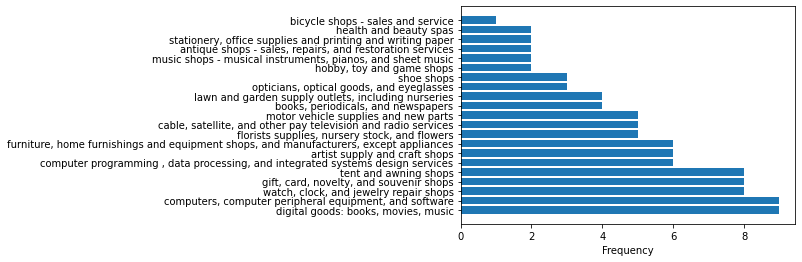

In [30]:
tags_count = top100_merch.groupBy("tags") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.barh(tags_count["tags"], tags_count["count"])
plt.xlabel("Frequency")

#### Segmented Ranking

Konw that we have 25 unique tags.

Assign tags to categories as follows:

**Hobbies: books, movies, music, and games**
- artist supply and craft shops
- books, periodicals, and newspapers
- digital goods: books, movies, music
- hobby, toy and game shops
- music shops - musical instruments, pianos, and sheet music

**Home and Office**
- cable, satellite, and other pay television and radio services
- computer programming , data processing, and integrated systems design services
- computers, computer peripheral equipment, and software
- equipment, tool, furniture, and appliance rent al and leasing
- furniture, home furnishings and equipment shops, and manufacturers, except appliances
- stationery, office supplies and printing and writing paper
- telecom

**Outdoors**
- bicycle shops - sales and service
- florists supplies, nursery stock, and flowers
- lawn and garden supply outlets, including nurseries
- motor vehicle supplies and new parts
- tent and awning shops

**Self-care and Fashion**
- health and beauty spas
- jewelry, watch, clock, and silverware shops
- opticians, optical goods, and eyeglasses
- shoe shops
- watch, clock, and jewelry repair shops

**Other**
- antique shops - sales, repairs, and restoration services
- art dealers and galleries
- gift, card, novelty, and souvenir shops

In [31]:
# store first word of every tag (know that each tag begins with a unique word)
segments_dic = {
    "Hobbies": ["artist", "books", "digital", "hobby", "music"],
    "Home and Office": ["cable", "computer", "computers", "equipment", "furniture", "stationery", "telecom"],
    "Outdoor": ["bicycle", "florists", "lawn", "motor", "tent"],
    "Self-care and Fashion": ["health", "jewelry", "opticians", "shoe", "watch"],
    "Other": ["antique", "art", "gift"]
}

Need to get top 10 merchants in each segment.

Following the same idea for the ranking system and noting the defined segments above, we obtain the following results:

In [32]:
seg_ranks_sdf = spark.read.parquet("../data/curated/seg_ranks.parquet")
seg_ranks_sdf

merchant_abn,company_name,tags,take_rate,revenue_band,segment,total_points,pop_points,trans_points,profit_points,mcust_points,rank
64403598239,Lobortis Ultrices...,music shops - mus...,6.31,a,Hobbies,42080.25,0.125,18022.5,37576.875,6007.5,1
72472909171,Nullam Consulting,digital goods: bo...,6.33,a,Hobbies,42032.125,0.0,18018.0,37526.5,6006.0,2
98973094975,Ornare Fusce Inc.,"hobby, toy and ga...",5.98,a,Hobbies,41918.5,0.0,17950.875,37432.0,5985.0,3
63290521567,Vehicula Pellente...,artist supply and...,6.48,a,Hobbies,41900.125,0.0,18036.0,37375.75,6012.0,4
49505931725,Suspendisse Ac As...,digital goods: bo...,4.70,b,Hobbies,41890.75,0.0,17990.625,37388.875,5994.0,5
35223308778,Euismod In Corp.,"books, periodical...",4.19,b,Hobbies,41775.625,0.0,17923.5,37292.875,5972.625,6
46298404088,Feugiat Sed Nec I...,"books, periodical...",6.16,a,Hobbies,41521.875,0.0,17892.0,37029.25,5964.875,7
34179569263,Sodales At LLC,music shops - mus...,4.72,b,Hobbies,41429.125,0.125,17621.625,37052.25,5871.625,8
15560455575,Morbi Accumsan La...,digital goods: bo...,4.08,b,Hobbies,41202.625,0.125,17761.5,36741.75,5920.75,9
75034515922,Ac Eleifend Corp.,digital goods: bo...,6.22,a,Hobbies,41140.0,0.0,17878.5,36622.0,5959.875,10


Observe frequency of tags for each segment

{'music shops - musical instruments, pianos, and sheet music': 2, 'digital goods: books, movies, music': 4, 'hobby, toy and game shops': 1, 'artist supply and craft shops': 1, 'books, periodicals, and newspapers': 2}
{'cable, satellite, and other pay television and radio services': 1, 'furniture, home furnishings and equipment shops, and manufacturers, except appliances': 3, 'computer programming , data processing, and integrated systems design services': 3, 'computers, computer peripheral equipment, and software': 3}
{'tent and awning shops': 3, 'florists supplies, nursery stock, and flowers': 5, 'motor vehicle supplies and new parts': 1, 'lawn and garden supply outlets, including nurseries': 1}
{'watch, clock, and jewelry repair shops': 6, 'opticians, optical goods, and eyeglasses': 2, 'shoe shops': 2}
{'gift, card, novelty, and souvenir shops': 8, 'antique shops - sales, repairs, and restoration services': 2}


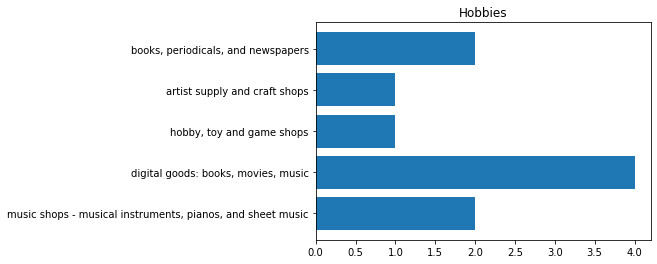

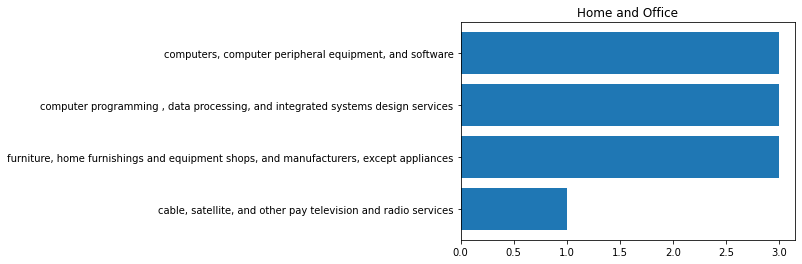

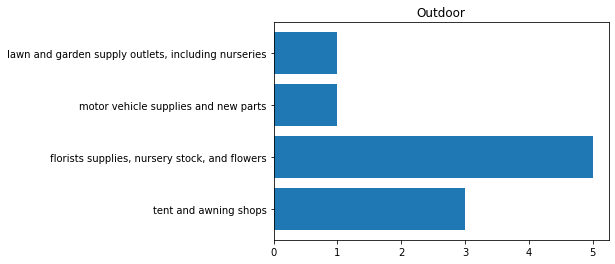

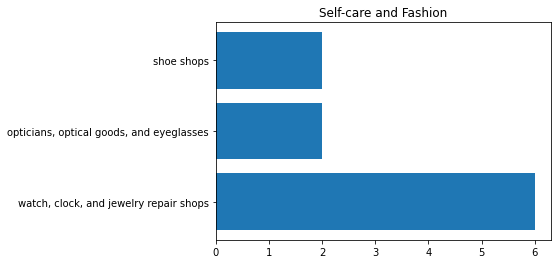

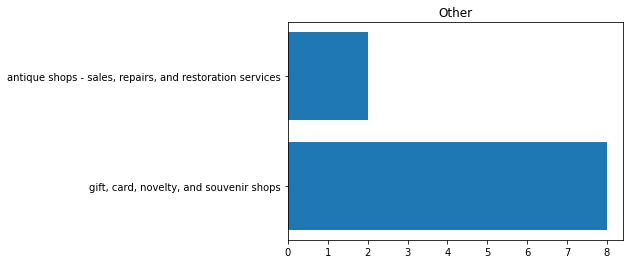

In [34]:
seg_ranks_df = seg_ranks_sdf.toPandas()
seg_ranks_grp = seg_ranks_df.groupby(["segment"])

i = 0
for segment in segments_dic.keys():
    top10 = seg_ranks_grp.get_group(segment)
    tags_count = dict(Counter(top10["tags"]))
    print(tags_count)

    plt.figure(i)
    plt.title(segment)
    plt.barh(list(tags_count.keys()), list(tags_count.values()))
    #plt.hist(top10["tags"], orientation='horizontal')

    i += 1
